In [1]:
import numpy as np
import os
import wfdb
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import requests

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [240]:
for i in range(1, 14):
    # Set up your dataset directory 
    print(str(i)+ " out of "+ str(13))
    directory = "dataset/S"+str(i)+"/"
    # Check if directory exist if not make one
    if not os.path.exists(directory):
        os.makedirs(directory)
    # Extract the all the experiments one after the other
    for e in range(1, 18):
        # URL experiment to be downloaded 
        url = "https://physionet.org/physiobank/database/pmd/experiment-i/S"+str(i)+"/"+ str(e)+".txt"
        r = requests.get(url) # create HTTP response object 
        # send a HTTP request to the server and save 
        # the HTTP response in a response object called r 
        with open( directory+str(e)+".txt",'w', encoding='utf8') as f: 
            f.write(r.text) 
print("Done")

1 out of 13
2 out of 13
3 out of 13
4 out of 13
5 out of 13
6 out of 13
7 out of 13
8 out of 13
9 out of 13
10 out of 13
11 out of 13
12 out of 13
13 out of 13
Done


In [245]:
def plot_data(subject):
    # Plot the various sleeping position recorded for a particular subject
    plt.figure(figsize = (20,20)) # width x height
    for i in range(1,18):
        data = np.loadtxt('dataset/S'+str(subject)+"/"+ str(i)+".txt")
        plt.subplot(5, 4, i)
        # Change index of data for another channel
        test = data[10].reshape(64,32)
        plt.imshow(test, cmap='hot')
        plt.tick_params(axis='both', which='both', bottom='off', top='off',
                    labelbottom='off', right='off', left='off', labelleft='off')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()        

C:\Users\ngoro\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


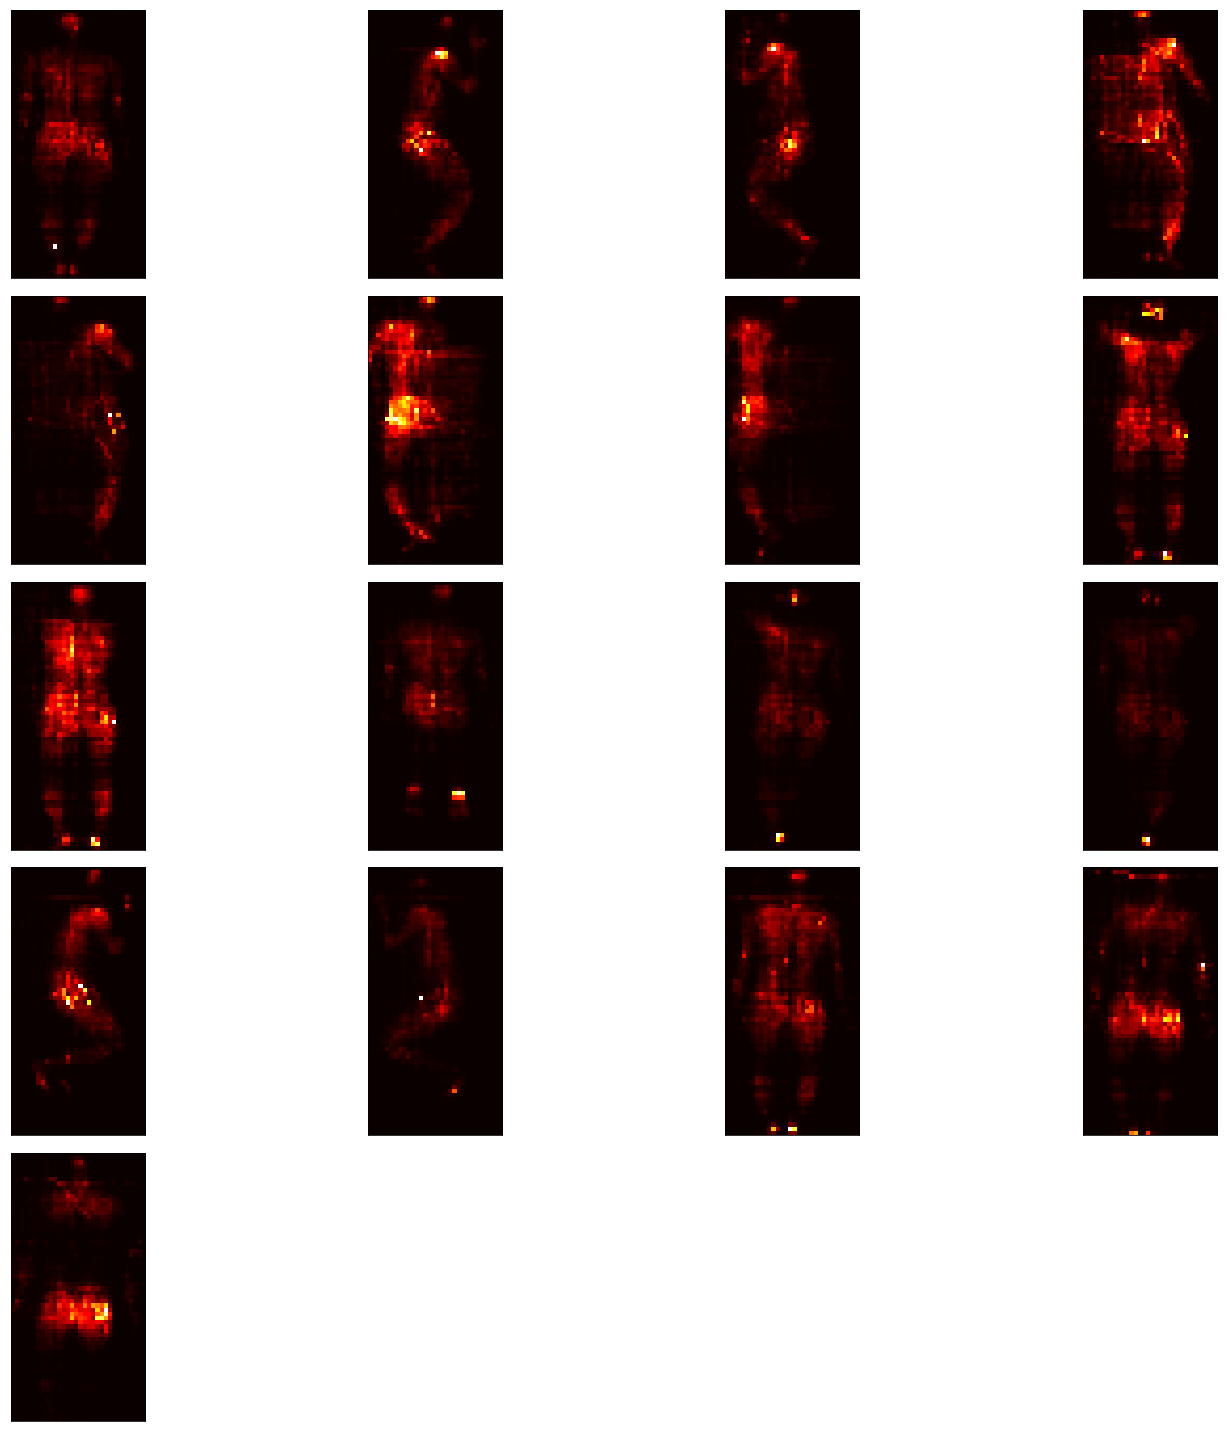

In [246]:
# Ploting data for subject 1
plot_data(1)

In [292]:
#@memory.cache()
# Generate the dataset with
# X = Sleeping position as a np matrix
# y = confortable or not as binary
def get_data(uncomfortable):
    # initialize the variables
    X = np.empty([67, 2048])
    y = []
    for i in range(1, 14):
        print(str(i) + " out of 13")
        for j in range(1,18):
            # Load up the data with the Subject and Position
            data = np.loadtxt('dataset/S'+str(i)+"/"+ str(j)+".txt")
            if j in uncomfortable:
                #data = np.append(data,np.ones([len(data),1]),1)
                # if the position corresponds to an uncofortable one
                # Add 1 in y (target variable) else 0
                for _ in range(0, data.shape[0]):
                    y.append(1)
            else:
                #data = np.append(data,np.zeros([len(data),1]),1)
                for _ in range(0, data.shape[0]):
                    y.append(0)
            X = np.append(X, data, 0)
            
    n = 67
    return X[n:,:],y



In [306]:
def score_solution(model, X_train, y_train, X_test, y_test, save = 0):
    '''
    Added a model and save parameter:
        model ~ hold a classification model 
        save ~ Flag used to save the best model on file using jobLib
    '''
    # Ask the solution for the model pipeline.
    pipeline = get_pipeline(model)
    error_message = 'Pipeline` implementation should ' \
        'return an `sklearn.pipeline.Pipeline`.'
    assert isinstance(pipeline, sklearn.pipeline.Pipeline), error_message
    # Train the model on the training 
    pipeline.fit(X_train, y_train)
    # Apply the model to the test DataFrame.
    y_pred = pipeline.predict_proba(X_test)
    # Check that the predicted probabilities have an sklearn-compatible shape.
    assert (y_pred.ndim == 1) or \
        (y_pred.ndim == 2 and y_pred.shape[1] == 2), \
        'The predicted probabilities should match sklearn''s ' \
        '`predict_proba` output shape`.'
    y_pred = y_pred if y_pred.ndim == 1 else y_pred[:, 1]
    # Evaluate the predictions with the AUC of the ROC curve.
    if (save==1): joblib.dump(pipeline, 'Best_Estimator.sav')
    return sklearn.metrics.roc_auc_score(y_test, y_pred)

def get_pipeline(model):            
    pipeline = Pipeline([
        model
    ])
    return pipeline

    pass

In [293]:
# Get the data
X,y = get_data([5,7])

1 out of 13
2 out of 13
3 out of 13
4 out of 13
5 out of 13
6 out of 13
7 out of 13
8 out of 13
9 out of 13
10 out of 13
11 out of 13
12 out of 13
13 out of 13


In [303]:
# Split daata in train and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=22)

In [313]:
# Run few classifiers on the dataset
models= [('LogisticRegression',LogisticRegression()),
             ('KNeighbors', KNeighborsClassifier()),
             ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
             ('DecisionTree ',tree.DecisionTreeClassifier()),
             ( 'RandomForest', RandomForestClassifier())
             ]
# Save result ROC Curve of each classifier in Dictionarry
res= {}
for e in models:
    res[e[0]]= [e ,score_solution(e, X_train, y_train, X_test, y_test,)]

print("Models   :  Roc Auc Value")
best= ""
m=0
for k,v in res.items():
    if v[1]> m: 
        best=k 
        m=v[1]
    print(k, " : ", v[1])

C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\ngoro\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Models   :  Roc Auc Value
LogisticRegression  :  0.9922596259792676
KNeighbors  :  0.9975294282809111
LinearDiscriminantAnalysis  :  0.9950330732055784
DecisionTree   :  0.9919829547810446
RandomForest  :  0.9986637907174445
